# Palmer Penguins Dataset
By Colin MacRae

I propose a multiclass classification task on the penguin dataset to determine the species of a penguin (there are three species in the dataset) and, time permitting, a binary classification task to determine the sex of a penguin. I would like to approach this task with a multilayer perceptron and a kernel SVM. I think these are appropriate models given the large number of numerical features. I also think it would be worthwhile to try recursive feature elimination and even SMOTE to attempt to improve model performance.

www.comacrae.com

## Introduction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras
from keras import layers
from google.colab import drive
import imblearn

drive.mount('/root/content/')

Mounted at /root/content/


In [2]:
path = '/root/content/My Drive/spr23/cs412/project/'
with open(path+'penguins.csv','r') as f:
  raw_data = pd.read_csv(f).drop(columns=['rowid'])
raw_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
null_vals = raw_data[raw_data.isna().any(axis=1) ]
null_vals.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,2007


In [4]:
raw_data_len = len(raw_data)
raw_data = raw_data.dropna()
print(f"Removed {((raw_data_len-len(raw_data))/raw_data_len)*100:.2f} % of samples")

Removed 3.20 % of samples


In [5]:
def convert_to_categorical(data,columns):
  cat_data = data.copy()
  for col in columns:
    cat_data[col] = pd.Categorical(cat_data[col])
    cat_data[col] = cat_data[col].cat.codes
  return cat_data

In [6]:
cat_df = convert_to_categorical(raw_data,['species','island','sex'])
cat_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,2,39.1,18.7,181.0,3750.0,1,2007
1,0,2,39.5,17.4,186.0,3800.0,0,2007
2,0,2,40.3,18.0,195.0,3250.0,0,2007
4,0,2,36.7,19.3,193.0,3450.0,0,2007
5,0,2,39.3,20.6,190.0,3650.0,1,2007


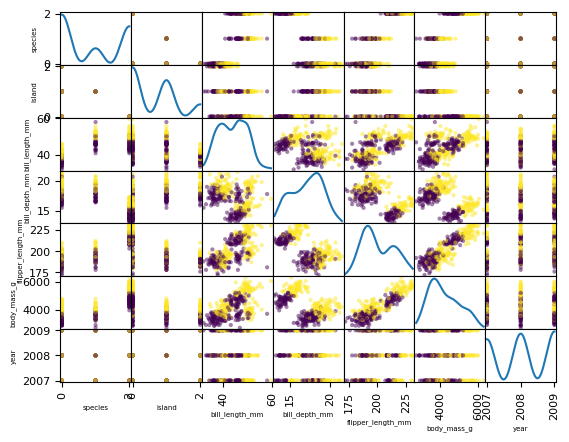

In [94]:
def print_scatter(data,target):
  axes = pd.plotting.scatter_matrix(data.loc[:,data.columns != target], diagonal='kde',c=data[target])
  [plt.setp(item.yaxis.get_label(), 'size', 5) for item in axes.ravel()]
  [plt.setp(item.xaxis.get_label(), 'size', 5) for item in axes.ravel()]

print_scatter(raw_data,'sex')

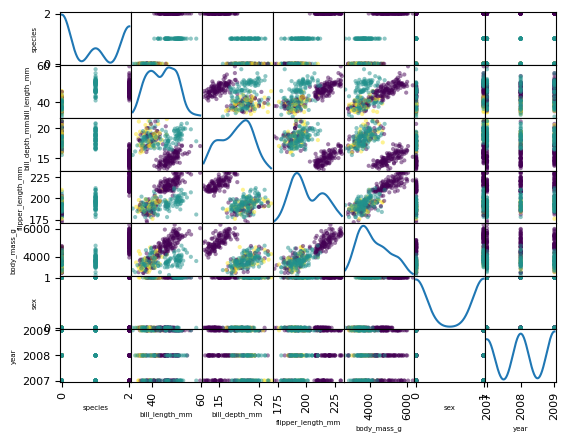

In [95]:
print_scatter(raw_data,'island')

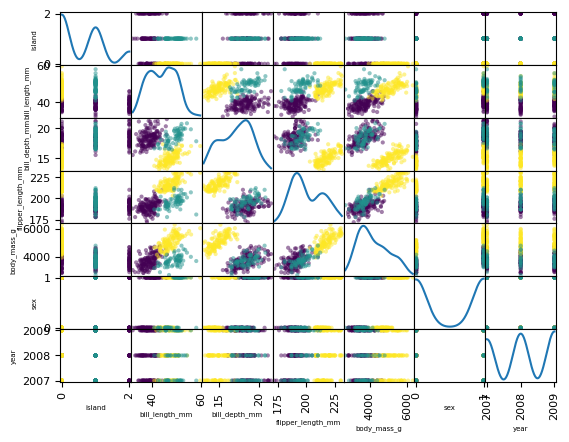

In [96]:
print_scatter(raw_data,'species')

Visualization

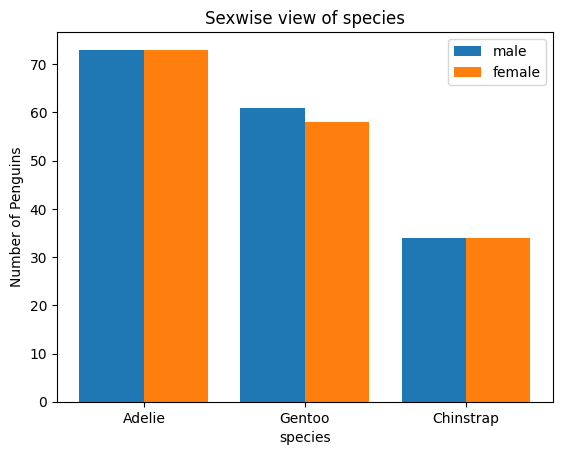

In [219]:
def print_sexwise_bar(data,target):
  data = data[[target,'sex']].value_counts().reset_index()
  data.columns = [target,'sex','counts']
  male = data[data['sex'] == 'male']
  female = data[data['sex'] == 'female']
  x = list(data[target].unique())
  x_axis = np.arange(data[target].nunique())
  plt.bar(x_axis-.2,male['counts'],0.4,label='male')
  plt.bar(x_axis+.2,female['counts'],0.4,label='female')
  plt.xticks(x_axis,x)
  plt.xlabel(target)
  plt.ylabel("Number of Penguins")
  plt.title(f"Sexwise view of {target}")
  plt.legend()
  plt.show()

print_sexwise_bar(raw_data,'species')

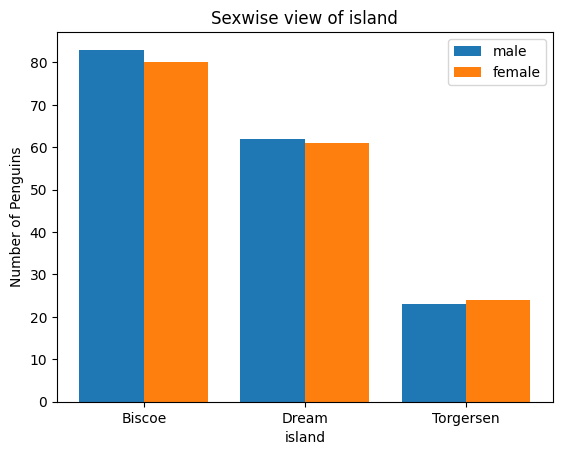

In [220]:
print_sexwise_bar(raw_data,'island')

0: female
1: male


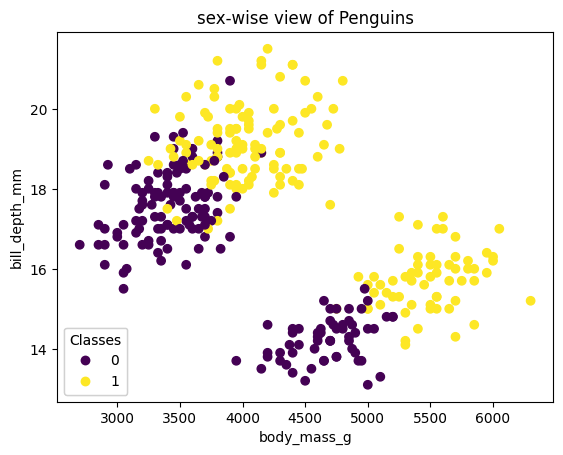

In [198]:
# get most relevant features for plotting scatterplots
def get_highest_corr(data,target):
  return np.abs(data.corr(numeric_only=True)[target]).sort_values(ascending=False)[1:]
def print_highest_corr_scatter(data,target):
  fig,ax = plt.subplots()
  cat_dict = {'species':['Adelie','Gentoo','Chinstrap'],
              'island':['Biscoe','Dream','Torgersen'],
              'sex':['female','male']}
  cols = [x for x in get_highest_corr(data,target).index if x not in ['species','island','sex']][:2]
  scatter = ax.scatter(data[cols[0]],data[cols[1]],c=data[target])
  plt.title(f"{target}-wise view of Penguins")
  if cols[0] in ['species','sex','island']:
    plt.xticks(np.arange(len(cat_dict[cols[0]])),cat_dict[cols[0]])
  if cols[1] in ['species','sex','island']:
    plt.xticks(np.arange(len(cat_dict[cols[1]])),cat_dict[cols[1]])
  legend1 = ax.legend(*scatter.legend_elements(),
                  loc="lower left", title="Classes")
  ax.add_artist(legend1)
  plt.xlabel(cols[0])
  plt.ylabel(cols[1])
  for i,name in enumerate(cat_dict[target]):
    print(f"{i}: {name}")
  plt.show()
print_highest_corr_scatter(cat_df,'sex')


0: Adelie
1: Gentoo
2: Chinstrap


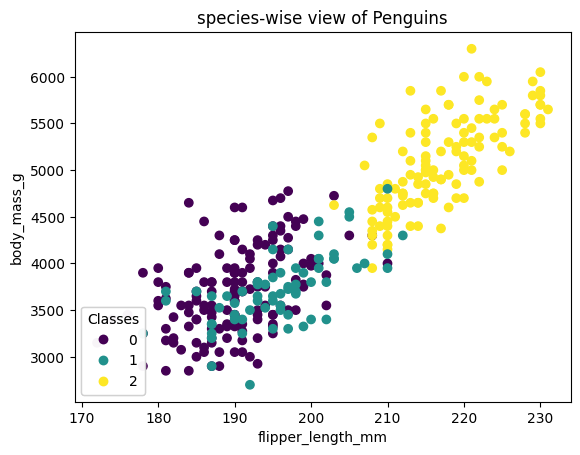

In [199]:
print_highest_corr_scatter(cat_df,'species')

0: Biscoe
1: Dream
2: Torgersen


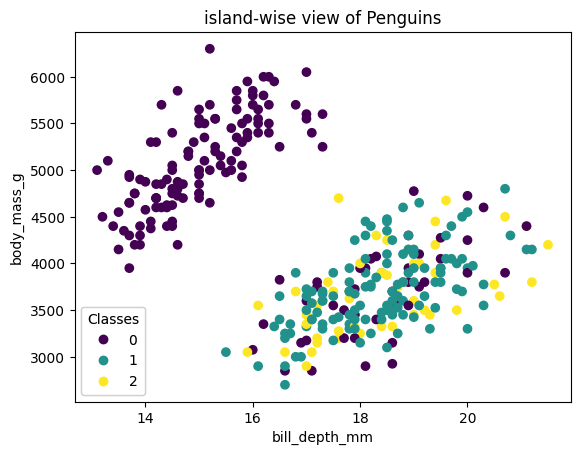

In [200]:
print_highest_corr_scatter(cat_df,'island')

The boxplot below suggestst that we will need to do scaling of our data

<Axes: >

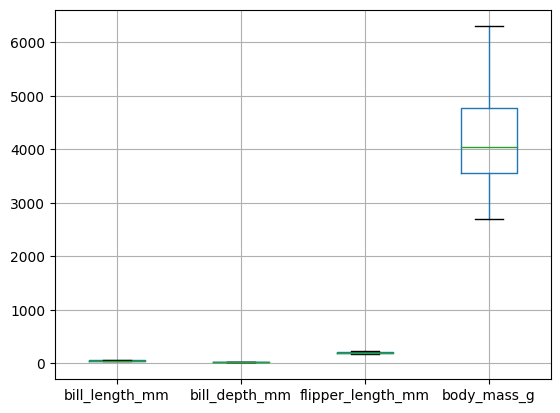

In [216]:
raw_data[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].boxplot()


<Axes: >

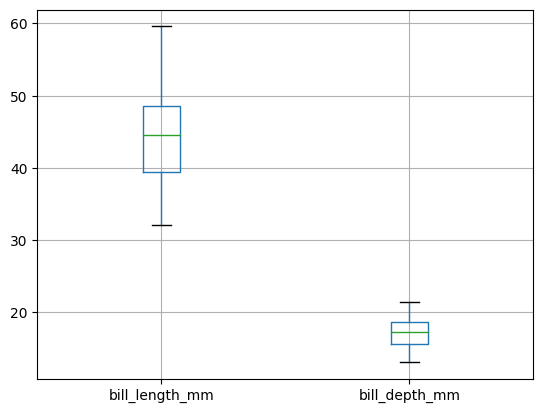

In [217]:
raw_data[['bill_length_mm','bill_depth_mm']].boxplot()

<Axes: >

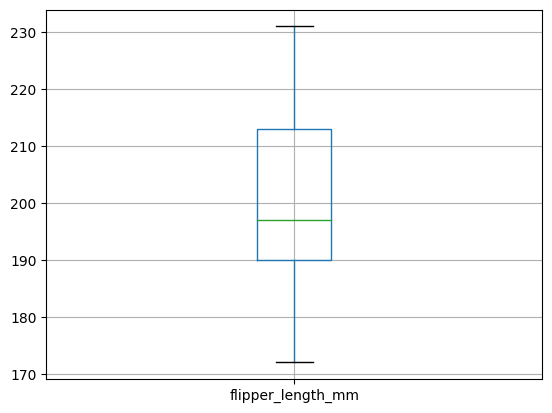

In [213]:
pd.DataFrame(raw_data[['flipper_length_mm']]).boxplot()

<Axes: >

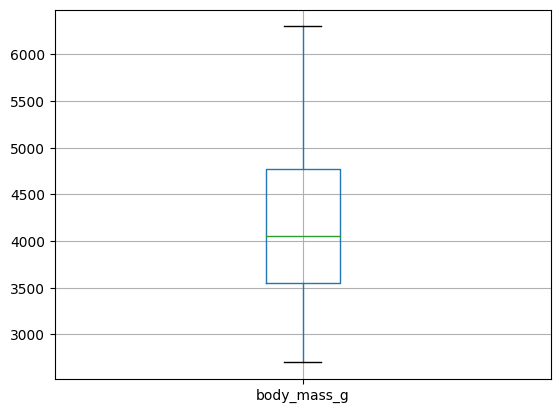

In [214]:
pd.DataFrame(raw_data[['body_mass_g']]).boxplot()

In [238]:
def plot_targetwise_yearly_trends(data,target):
  feats = ['bill_length_mm','bill_depth_mm','body_mass_g','flipper_length_mm']
  for feat in feats:
    target_agg = data.groupby(target)
    print(target_agg)
    for val in list(data[target].unique()):
      target_agg[val][feat].agg(['min','max','mean'])
      print(target_agg)
      #min = agg['min']
      #max = agg['max']
      #mean = agg['mean']
    plt.plot(list(data.year.unique()),mean)
plot_targetwise_yearly_trends(raw_data,'species')

KeyError: ignored